# Persistent Homology on Health Centers in California

This Jupyter Notebook is based of the Jupyter Notebook Produced in "Persistent Homology for Resource Coverage: A Case Study of Access to Polling Sites"
DOI: 10.1137/22M150410X
Link to repository: https://bitbucket.org/jerryluo8/coveragetda/src/main/

In [1]:
# from google.colab import drive, files
# drive.mount('/content/drive')
# pathname = "/content/drive/Shared with me/TDA for Resource Access/"
# import sys
# sys.path.append(pathname)
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

### Installing necessary packages

In [2]:
%pip install contextily
%pip install cartopy
%pip install geopandas
%pip install gudhi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Gudhi Plotting

In [ ]:
import numpy as np
import gudhi as gd
from gudhi import RipsComplex
import matplotlib.pyplot as plt

def get_unweighted_rips_info(points, max_edge_length=1.0, max_hom_dim=1):
    '''
    points: (n_points x d) array of coordinates
    max_edge_length: threshold distance for Rips complex
    max_hom_dim: maximum homology dimension
    '''
    rips_complex = RipsComplex(points=points, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_hom_dim + 1)
    simplex_tree.compute_persistence()
    persistence = simplex_tree.persistence()
    return simplex_tree, persistence, simplex_tree.persistence_pairs()

#### Applying functions from the Gudhi Library

<Figure size 1000x800 with 0 Axes>

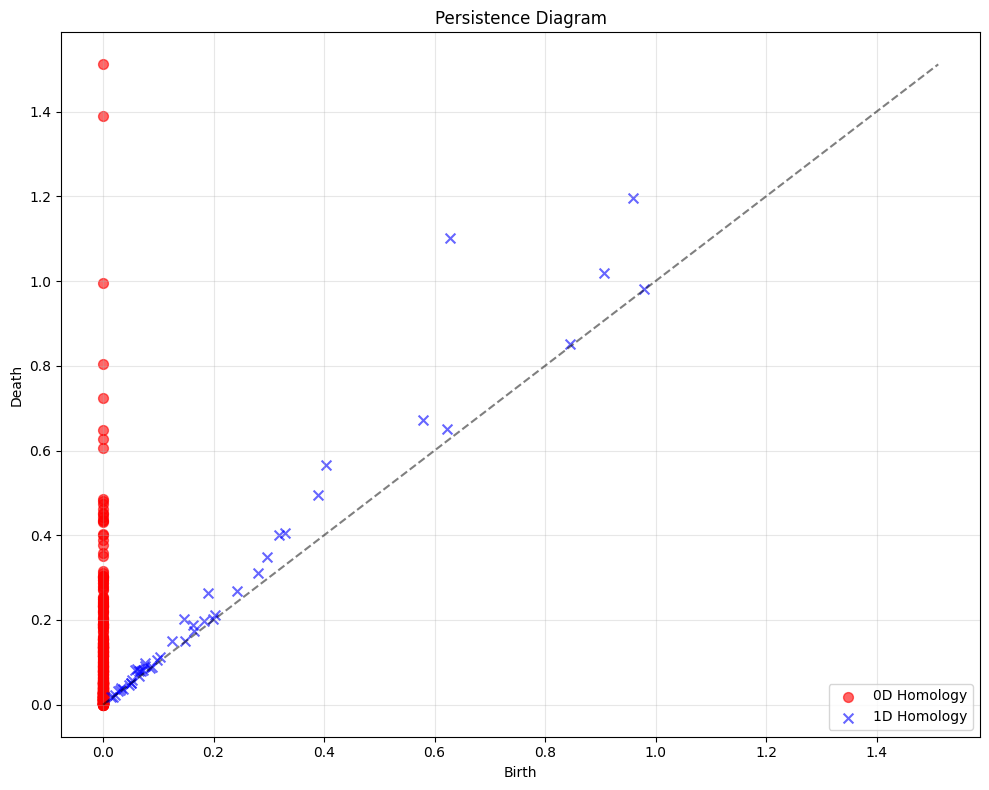

In [ ]:
# This file is part of the Gudhi Library - https://gudhi.inria.fr/ - which is released under MIT.
# See file LICENSE or go to https://gudhi.inria.fr/licensing/ for full license details.
# Author(s):       Vincent Rouvreau, Bertrand Michel
#
# Copyright (C) 2016 Inria
#
# Modification(s):
#   - 2020/02 Theo Lacombe: Added more options for improved rendering and more flexibility.
#   - YYYY/MM Author: Description of the modification
from os import path
from math import isfinite
import numpy as np
from functools import lru_cache

__author__ = "Vincent Rouvreau, Bertrand Michel, Theo Lacombe"
__copyright__ = "Copyright (C) 2016 Inria"
__license__ = "MIT"

_gudhi_matplotlib_use_tex = True

def __min_birth_max_death(persistence, band=0.0):
    """This function returns (min_birth, max_death) from the persistence.

    :param persistence: The persistence to plot.
    :type persistence: list of tuples(dimension, tuple(birth, death)).
    :param band: band
    :type band: float.
    :returns: (float, float) -- (min_birth, max_death).
    """
    # Look for minimum birth date and maximum death date for plot optimisation
    max_death = 0
    min_birth = persistence[0][1][0]
    for interval in reversed(persistence):
        if float(interval[1][1]) != float("inf"):
            if float(interval[1][1]) > max_death:
                max_death = float(interval[1][1])
        if float(interval[1][0]) > max_death:
            max_death = float(interval[1][0])
        if float(interval[1][0]) < min_birth:
            min_birth = float(interval[1][0])
    if band > 0.0:
        max_death += band
    return (min_birth, max_death)


def _array_handler(a):
    '''
    :param a: if array, assumes it is a (n x 2) np.array and return a
                persistence-compatible list (padding with 0), so that the
                plot can be performed seamlessly.
    '''
    if isinstance(a[0][1], np.float64) or isinstance(a[0][1], float):
        return [[0, x] for x in a]
    else:
        return a

@lru_cache(maxsize=1)
def _matplotlib_can_use_tex():
    """This function returns True if matplotlib can deal with LaTeX, False otherwise.
    The returned value is cached.
    """
    try:
        from matplotlib import checkdep_usetex
        return checkdep_usetex(True)
    except ImportError:
        print("This function is not available, you may be missing matplotlib.")

# Plotting Persistence Diagram
def plot_persistence_diagram_fixed(persistence, alpha=0.6, max_intervals=1000, legend=True):
    try:
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatches
        
        # Handle the persistence format
        if hasattr(persistence, '__iter__'):
            persistence_list = list(persistence)
        else:
            persistence_list = persistence
            
        if not persistence_list:
            print("No persistence intervals found!")
            return
            
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Get min/max values for plotting
        finite_intervals = [(dim, birth, death) for dim, (birth, death) in persistence_list 
                        if death != float('inf')]
        
        if not finite_intervals:
            print("No finite intervals found!")
            return ax
            
        births = [birth for _, birth, death in finite_intervals]
        deaths = [death for _, birth, death in finite_intervals]
        
        min_val = min(min(births), min(deaths))
        max_val = max(max(births), max(deaths))
        
        # Plot diagonal
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        # Plot points by dimension
        colors = ['red', 'blue', 'green', 'orange']
        markers = ['o', 'x', 's', '^']
        
        for dim in range(2):  # 0D and 1D
            dim_intervals = [(birth, death) for d, birth, death in finite_intervals if d == dim]
            if dim_intervals:
                births, deaths = zip(*dim_intervals)
                ax.scatter(births, deaths, 
                        c=colors[dim], 
                        marker=markers[dim],
                        alpha=alpha, 
                        s=50,
                        label=f'{dim}D Homology')
        
        if legend:
            ax.legend()
            
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
        ax.set_title('Persistence Diagram')
        ax.grid(True, alpha=0.3)
        
        return ax
        
    except Exception as e:
        print(f"Error in plotting persistence diagram: {e}")
        return None

# Use the fixed version
plt.figure(figsize=(10, 8))
#plot_persistence_diagram_fixed(ph, legend=True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import gudhi as gd
import os
from gudhi import RipsComplex
    
def get_tda_info(citypath, city, max_hom_dim = 1):
    '''
    citypath: string. path where data/travel time matrices are stored. 
        In TDA for Resource Access Drive, this is one of {Atlanta, Chicago, Jacksonville, Los Angeles, NYC, Salt Lake City}.
    city: {atl, chc, jax, lac, manbronx, queensbrook, stat, slc}
    Assume that distance matrix is already computed and saved at citypath + f'/{city}_d_matrix.npy'
    '''
    # Load distance matrix and wait times (the weights for the weighted Rips complex)
    D_city = np.load(os.path.join(citypath, f'{city}_d_matrix.npy'))
    #D_city = np.genfromtxt(citypath + f'/{city}_d_matrix.csv', delimiter = ",")
    
    # Calculate simplex pairs for the homology classes
    cpx = RipsComplex(distance_matrix = D_city).create_simplex_tree(max_dimension = max_hom_dim + 1)
    cpx.compute_persistence()
    ph = cpx.persistence()
    all_pairs = cpx.persistence_pairs()
    return cpx, ph, all_pairs

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Polygon
import scipy.stats

def plot_deathsimplices(geojson_file, distance_matrix_file, cpx, all_pairs, hom_dim, ax, criteria = 'death', zscore_thresh = 1, citydf_fname = None, vmin0 = 3235, vmin1 = 4410, vmax0 = 7380, vmax1 = 7942, legend = False):
    '''
    citypath: string. path where data/travel time matrices are stored. 
        In TDA for Resource Access Drive, this is one of {Atlanta, Chicago, Jacksonville, Los Angeles, NYC, Salt Lake City}.
    city: {atl, chc, jax, lac, lac_NoCatalina, nyc, slc}
    cpx: The filtered complex, as computed by get_cpx_spxpairs. Assume ph has already been computed
    all_pairs: All (birth simplex, death simplex) pairs for the ph of cpx, as computed by get_cpx_spxpairs
    hom_dim: {0, 1}. Homology dimension.
    ax: ax to plot on. (This is passed as an argument so that we can overlay multiple death simplex plots on top of each other, e.g. for NYC)
    criteria: {'lifetime', 'death'}. For each homology class, either compute lifetimes (death - birth) or just death
    zscore_thresh: (float) optional , default 1. We compute the z-score for the criteria value for each homology class that has finite criteria value.
    vmax0: (float) optional, default 6500. we want this to be higher than the highest death filtration of 0th homology
    vmax1: (float) optional, default 8100. same thing as vmax0, but for 1st homology
    
    Plot death simplices for finite homology classes with an z-score above zscore_thresh, in dimension hom_dim.
    '''
    
    gdf = gpd.read_file(geojson_file)
    distance_matrix = np.load(distance_matrix_file)
    
    # Verify dimensions match
    assert len(gdf) == distance_matrix.shape[0] == distance_matrix.shape[1], \
        "Distance matrix dimensions must match number of GeoJSON features"
    
    print(f"Loaded {len(gdf)} points from {geojson_file}")
    print(f"Distance matrix shape: {distance_matrix.shape}")
    # Get simplex pairs for homology classes in dimension hom_dim. 
    # Only get the finite homology classes (i.e., the ones that have a death simplex)
    # Filter out infinite death times (similar to persistence diagram handling)
    pairs = []
    for pair in all_pairs:
        if len(pair[1]) == hom_dim + 2:  # Check dimension
            death_time = cpx.filtration(pair[1])
            if death_time != float("inf") and not np.isinf(death_time):  # Only finite death times
                pairs.append(pair)
    
    # Check if we have any pairs to work with
    if not pairs:
        print(f"No finite homology classes found in dimension {hom_dim}")
        return None
    
    print(f"Found {len(pairs)} finite homology classes in dimension {hom_dim}")
    
    # Calculate criteria, sort death simplices by criteria, calculate z-scores
    deathspx_criteria = []
    for pair in pairs:
        birth_time = cpx.filtration(pair[0])
        death_time = cpx.filtration(pair[1])
        
        if criteria == "death":
            criteria_val = death_time
        elif criteria == "lifetime":
            criteria_val = death_time - birth_time
        else:
            raise ValueError("criteria must be 'death' or 'lifetime'")
        
        deathspx_criteria.append([pair[1], criteria_val])
    
    if not deathspx_criteria:
        print(f"No valid criteria values computed for dimension {hom_dim}")
        return None
    
    deathspx_criteria.sort(key=lambda row: row[1], reverse=True)
    death_simplices = [item[0] for item in deathspx_criteria]
    criteria_vals = [item[1] for item in deathspx_criteria]
    zscores = scipy.stats.zscore(criteria_vals)
    
    # Make geopandas dataframe where the polygons represent the death simplices
    geometries = []
    valid_criteria = []
    valid_zscores = []
    for i, deathspx in enumerate(death_simplices):
        try:
            # Check if all indices are valid
            if all(0 <= idx < len(gdf) for idx in deathspx):
                if hom_dim == 0:
                    # Create LineString from two points and buffer it
                    points = [gdf.geometry.iloc[deathspx[j]] for j in range(2)]
                    line_geom = LineString(points)
                    geometries.append(line_geom.buffer(0.005))
                elif hom_dim == 1:
                    # Create Polygon from three points
                    points = [gdf.geometry.iloc[deathspx[j]] for j in range(3)]
                    polygon_geom = Polygon(points)
                    geometries.append(polygon_geom)
                
                valid_criteria.append(criteria_vals[i])
                valid_zscores.append(zscores[i])
            else:
                print(f"Invalid indices in simplex {deathspx}: max index {max(deathspx)}, but only {len(gdf)} points available")
                
        except Exception as e:
            print(f"Error creating geometry for simplex {deathspx}: {e}")
            continue
    
    if not geometries:
        print("No valid geometries created")
        return None
    
    df_deathsimplices = gpd.GeoDataFrame(geometry=geometries)
    df_deathsimplices['criteria'] = valid_criteria
    df_deathsimplices['zscore'] = valid_zscores
    
    
    # Filter by zscore threshold
    df_deathsimplices_truncated = df_deathsimplices[df_deathsimplices['zscore'] > zscore_thresh]
    
    print(f"Total death simplices: {len(df_deathsimplices)}")
    print(f"Death simplices above zscore threshold ({zscore_thresh}): {len(df_deathsimplices_truncated)}")
    
    # Plot
    ax.set_axis_off()
    
    # Plot the base points
    gdf.plot(ax=ax, markersize=1, color='blue', alpha=0.6)
    
    # Set color scale limits based on homology dimension
    if hom_dim == 0:
        vmin = vmin0
        vmax = vmax0
    else:
        vmin = vmin1
        vmax = vmax1
    
    # Only plot if we have data to plot
    if len(df_deathsimplices_truncated) > 0:
        # Use a colormap similar to the persistence diagram
        df_deathsimplices_truncated.plot(
            'criteria', 
            ax=ax, 
            alpha=0.7, 
            vmin=vmin, 
            vmax=vmax, 
            legend=legend, 
            cmap='plasma'  # Changed to plasma for better contrast
        )
        print(f"Plotted {len(df_deathsimplices_truncated)} death simplices")
        
        # Add colorbar if legend is requested
        if legend:
            import matplotlib.pyplot as plt
            sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label(f'{criteria.capitalize()} time', rotation=270, labelpad=15)
            
    else:
        print("No death simplices above zscore threshold to plot")
    
    return df_deathsimplices_truncated

    df_deathsimplices_truncated.plot('criteria', ax=ax, alpha=0.7, vmin = vmin, vmax = vmax, legend = legend)

In [ ]:
# retrying plotting death simplices 
# NEW SIMPLIFIED FUNCTIONS - ADD THIS AS A NEW CELL
def simple_persistence_plot(persistence):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Separate 0D and 1D homology classes
    dim0_points = []
    dim1_points = []
    
    for interval in persistence:
        dim, (birth, death) = interval
        if death != float('inf'):  # Only finite intervals
            if dim == 0:
                dim0_points.append((birth, death))
            elif dim == 1:
                dim1_points.append((birth, death))
    
    # Plot points
    if dim0_points:
        births_0, deaths_0 = zip(*dim0_points)
        ax.scatter(births_0, deaths_0, c='red', s=50, alpha=0.7, label='0D Homology')
    
    if dim1_points:
        births_1, deaths_1 = zip(*dim1_points)
        ax.scatter(births_1, deaths_1, c='blue', s=50, alpha=0.7, label='1D Homology')
    
    # Add diagonal line
    if dim0_points or dim1_points:
        all_points = dim0_points + dim1_points
        all_births, all_deaths = zip(*all_points)
        min_val = min(min(all_births), min(all_deaths))
        max_val = max(max(all_births), max(all_deaths))
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.set_title('Persistence Diagram')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

def simple_plot_death_simplices(gdf, cpx, all_pairs, hom_dim, ax, criteria='death', zscore_thresh=1):
    """
    Simplified version of death simplices plotting
    """
    from scipy import stats
    from shapely.geometry import LineString, Polygon
    
    # Get simplex pairs for the specified homology dimension
    pairs = []
    for pair in all_pairs:
        if len(pair[1]) == hom_dim + 2:  # Check dimension (0D->2 vertices, 1D->3 vertices)
            death_time = cpx.filtration(pair[1])
            if death_time != float("inf") and not np.isinf(death_time):
                pairs.append(pair)
    
    if not pairs:
        print(f"No finite homology classes found in dimension {hom_dim}")
        return None
    
    print(f"Found {len(pairs)} finite homology classes in dimension {hom_dim}")
    
    # Calculate criteria values
    criteria_values = []
    death_simplices = []
    
    for pair in pairs:
        birth_time = cpx.filtration(pair[0])
        death_time = cpx.filtration(pair[1])
        
        if criteria == "death":
            criteria_val = death_time
        elif criteria == "lifetime":
            criteria_val = death_time - birth_time
        else:
            criteria_val = death_time
            
        criteria_values.append(criteria_val)
        death_simplices.append(pair[1])
    
    # Calculate z-scores
    if len(criteria_values) > 1:
        zscores = stats.zscore(criteria_values)
    else:
        zscores = [0]
    
    # Filter by z-score threshold
    significant_indices = [i for i, z in enumerate(zscores) if z > zscore_thresh]
    
    if not significant_indices:
        print(f"No death simplices above zscore threshold ({zscore_thresh})")
        return None
    
    print(f"Death simplices above zscore threshold: {len(significant_indices)}")
    
    # Plot base points
    gdf.plot(ax=ax, markersize=20, color='blue', alpha=0.6, edgecolor='black')
    
    # Create geometries for death simplices
    geometries = []
    colors = []
    
    for i in significant_indices:
        simplex = death_simplices[i]
        criteria_val = criteria_values[i]
        
        try:
            if all(0 <= idx < len(gdf) for idx in simplex):
                if hom_dim == 0:  # 0D -> plot edge (line)
                    if len(simplex) >= 2:
                        points = [gdf.geometry.iloc[simplex[j]] for j in range(2)]
                        line_geom = LineString(points).buffer(0.03)  # Small buffer to make it visible
                        geometries.append(line_geom)
                        colors.append(criteria_val)
                        
                elif hom_dim == 1:  # 1D -> plot triangle
                    if len(simplex) >= 3:
                        points = [gdf.geometry.iloc[simplex[j]] for j in range(3)]
                        # Check if points are valid for polygon
                        coords = [(p.x, p.y) for p in points]
                        if len(set(coords)) >= 3:  # Need at least 3 unique points
                            polygon_geom = Polygon(coords)
                            geometries.append(polygon_geom)
                            colors.append(criteria_val)
                            
        except Exception as e:
            print(f"Error creating geometry for simplex {simplex}: {e}")
            continue
    
    if not geometries:
        print("No valid geometries created")
        return None
    
    # Create GeoDataFrame for death simplices
    df_death = gpd.GeoDataFrame({'criteria': colors}, geometry=geometries)
    
    # Plot death simplices
    if len(df_death) > 0:
        df_death.plot(
            column='criteria',
            ax=ax,
            alpha=0.7,
            cmap='viridis',
            legend=True,
            legend_kwds={'label': f'{criteria.capitalize()} value'}
        )
        print(f"Plotted {len(df_death)} death simplices")
    
    ax.set_title(f"Death Simplices - {hom_dim}D Homology (zscore > {zscore_thresh})")
    ax.set_axis_off()
    
    return df_death

In [ ]:
#addding enhanced plot 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import geopandas as gpd

# First, let's get California boundaries or create a basemap
def create_basemap_with_boundaries(gdf, ax):
    """Create a basemap with geographic boundaries"""
    
    # Option A: Use Natural Earth data for administrative boundaries
    try:
        # Get state boundaries
        shpfilename = shapereader.natural_earth(resolution='10m', 
                                            category='cultural', 
                                            name='admin_1_states_provinces')
        states = gpd.read_file(shpfilename)
        california = states[states['name'] == 'California']
        
        # Plot California boundary
        california.boundary.plot(ax=ax, color='black', linewidth=1)
        
        # Optionally add county boundaries
        county_shp = shapereader.natural_earth(resolution='10m',
                                            category='cultural', 
                                            name='admin_2_counties')
        counties = gpd.read_file(county_shp)
        ca_counties = counties[counties['admin'] == 'California']
        ca_counties.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.7)
        
    except:
        # Fallback: just plot a simple boundary around your points
        bounds = gdf.bounds
        from matplotlib.patches import Rectangle
        rect = Rectangle((bounds.minx.min(), bounds.miny.min()), 
                        bounds.maxx.max() - bounds.minx.min(),
                        bounds.maxy.max() - bounds.miny.min(),
                        linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

def enhanced_death_simplices_plot(gdf, cpx, all_pairs, hom_dim, ax, zscore_thresh=1):
    """Enhanced plotting to match the style in your image"""
    
    from scipy import stats
    from shapely.geometry import LineString, Polygon
    
    # Add geographic boundaries first
    create_basemap_with_boundaries(gdf, ax)
    
    # Get death simplices data
    pairs = []
    for pair in all_pairs:
        if len(pair[1]) == hom_dim + 2:
            death_time = cpx.filtration(pair[1])
            if death_time != float("inf") and not np.isinf(death_time):
                pairs.append(pair)
    
    if not pairs:
        print(f"No finite homology classes found in dimension {hom_dim}")
        return None
    
    # Calculate criteria and z-scores
    criteria_values = [cpx.filtration(pair[1]) for pair in pairs]
    death_simplices = [pair[1] for pair in pairs]
    
    if len(criteria_values) > 1:
        zscores = stats.zscore(criteria_values)
    else:
        zscores = [0]
    
    # Filter by threshold
    significant_indices = [i for i, z in enumerate(zscores) if z > zscore_thresh]
    
    if not significant_indices:
        print(f"No death simplices above zscore threshold ({zscore_thresh})")
        return None
    
    # Plot health centers as small dots
    gdf.plot(ax=ax, markersize=2, color='blue', alpha=0.8)
    
    # Create and plot death simplices with colors similar to your image
    geometries = []
    colors = []
    
    for i in significant_indices:
        simplex = death_simplices[i]
        criteria_val = criteria_values[i]
        
        try:
            if all(0 <= idx < len(gdf) for idx in simplex):
                if hom_dim == 0 and len(simplex) >= 2:
                    # Create buffered lines for 0D death simplices
                    points = [gdf.geometry.iloc[simplex[j]] for j in range(2)]
                    line_geom = LineString(points).buffer(0.02)  # Adjust buffer size
                    geometries.append(line_geom)
                    colors.append(criteria_val)
                    
                elif hom_dim == 1 and len(simplex) >= 3:
                    # Create triangles for 1D death simplices
                    points = [gdf.geometry.iloc[simplex[j]] for j in range(3)]
                    coords = [(p.x, p.y) for p in points]
                    if len(set(coords)) >= 3:
                        polygon_geom = Polygon(coords)
                        geometries.append(polygon_geom)
                        colors.append(criteria_val)
                        
        except Exception as e:
            continue
    
    if geometries:
        # Create GeoDataFrame and plot with styling similar to your image
        df_death = gpd.GeoDataFrame({'criteria': colors}, geometry=geometries)
        df_death.plot(
            column='criteria',
            ax=ax,
            alpha=0.8,
            cmap='viridis',  # Try different colormaps: 'plasma', 'viridis', 'Blues'
            edgecolor='white',
            linewidth=0.5
        )
    
    # Final styling
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(f'Death Simplices - {hom_dim}D Homology (zscore > {zscore_thresh})', 
                fontsize=14, pad=20)
    
    return df_death


Running on all cities

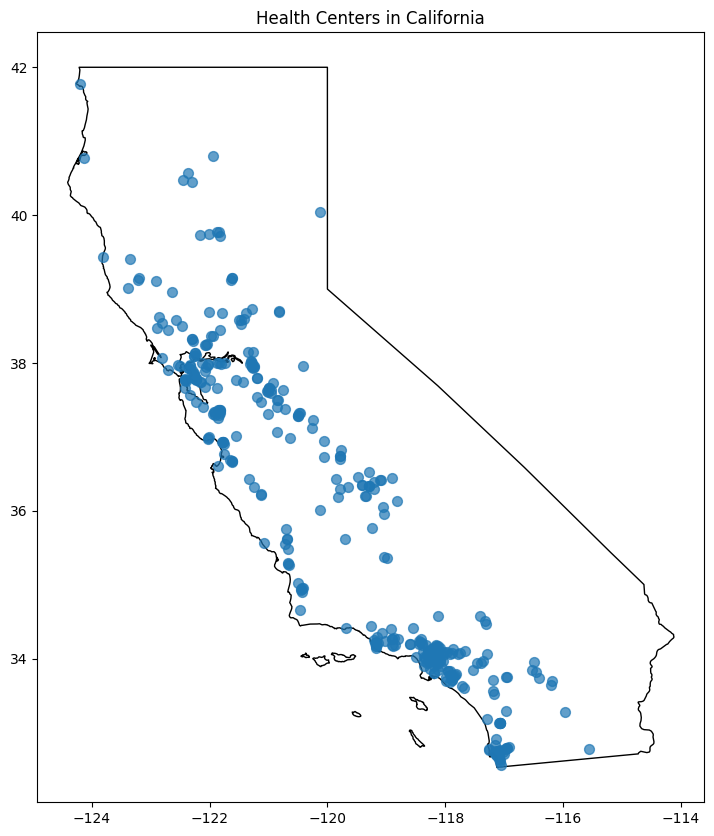

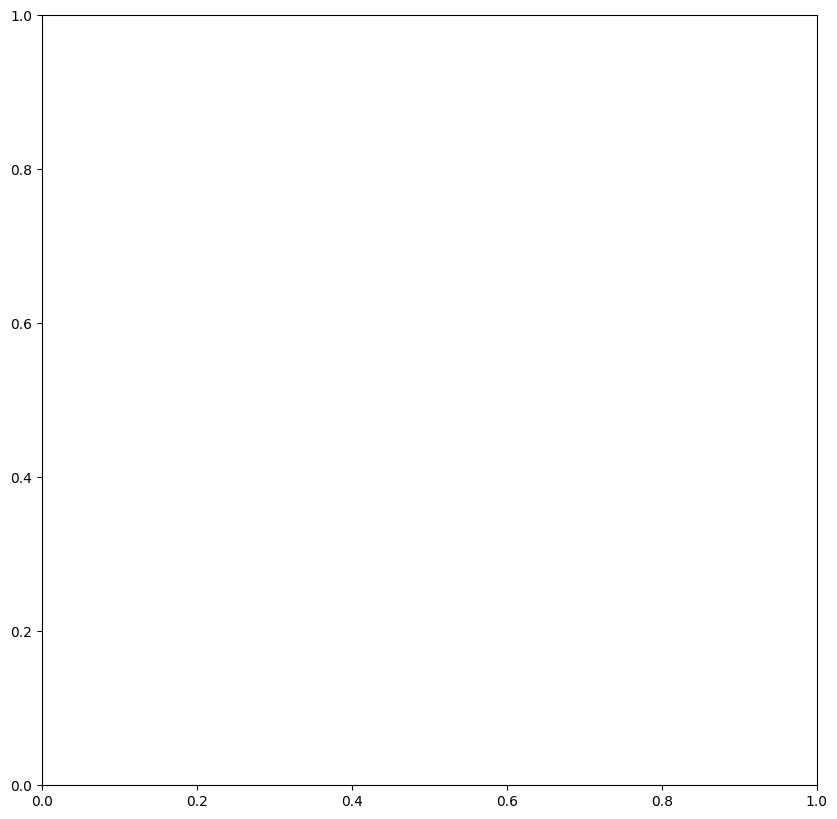

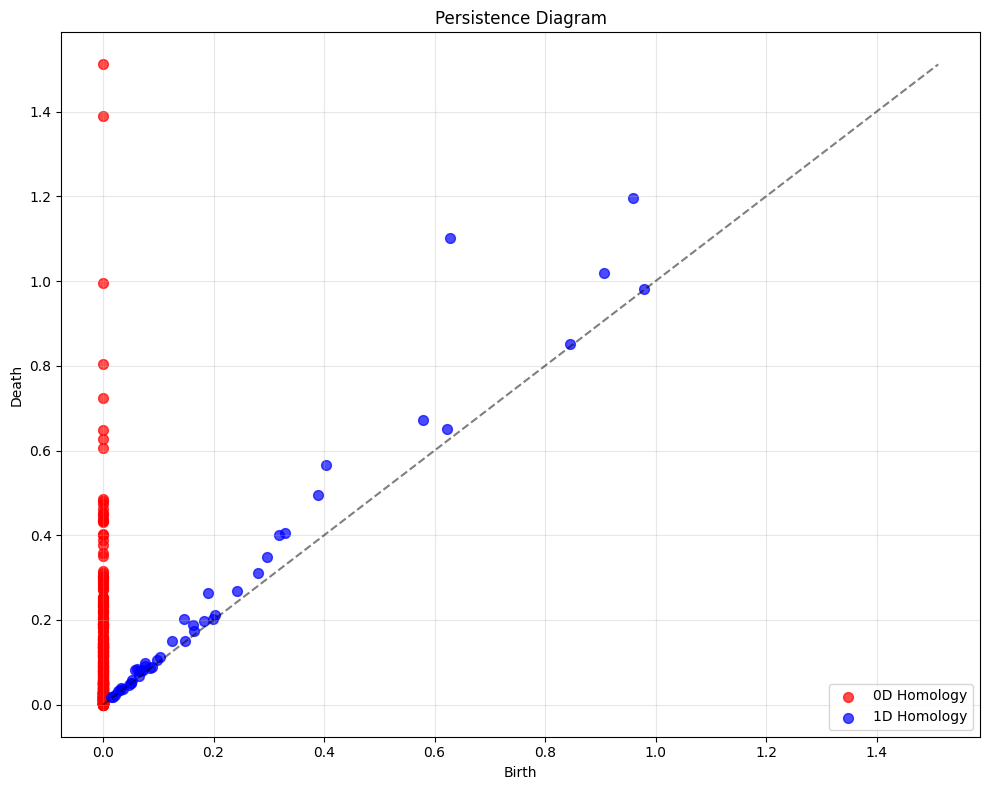

Found 408 finite homology classes in dimension 0
Death simplices above zscore threshold: 39
Plotted 39 death simplices


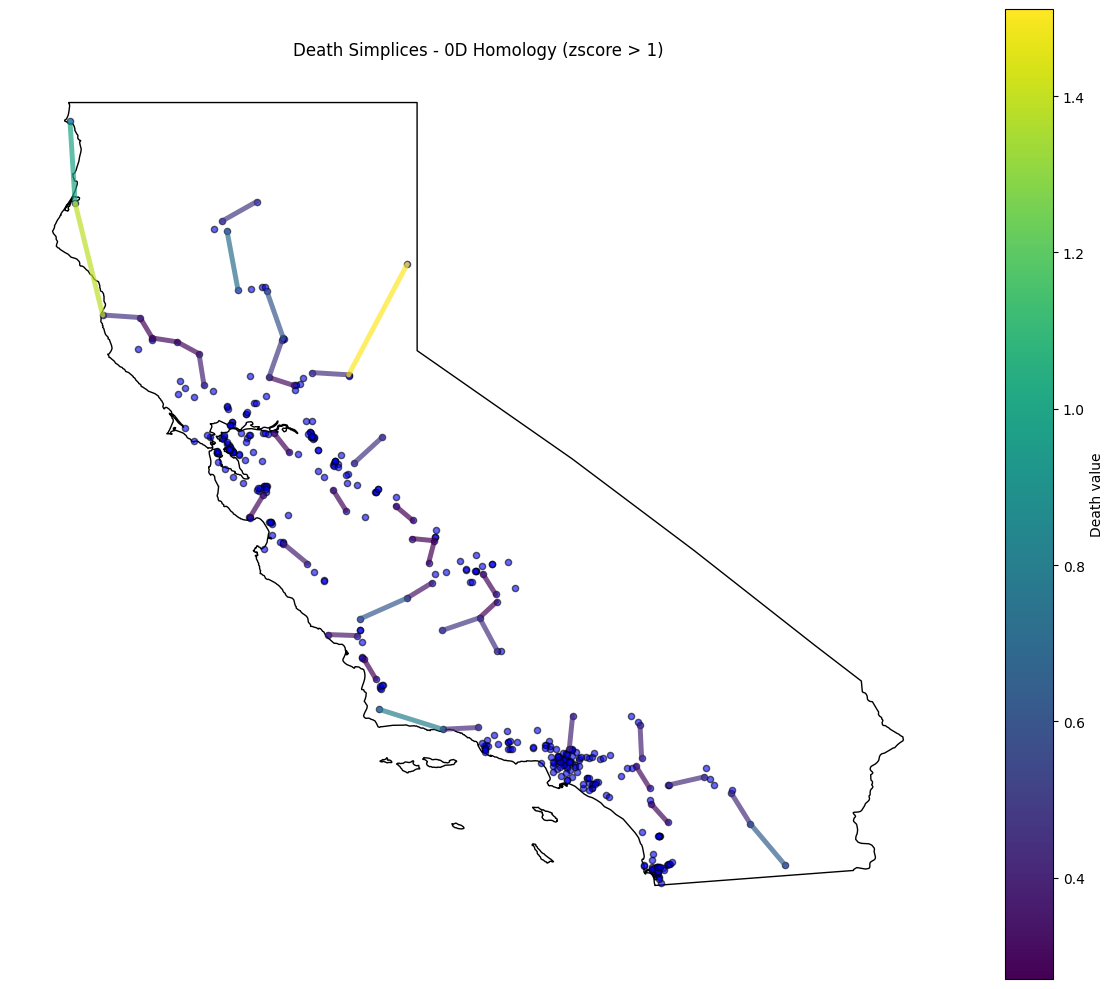

Found 46 finite homology classes in dimension 1
Death simplices above zscore threshold: 7
Plotted 7 death simplices


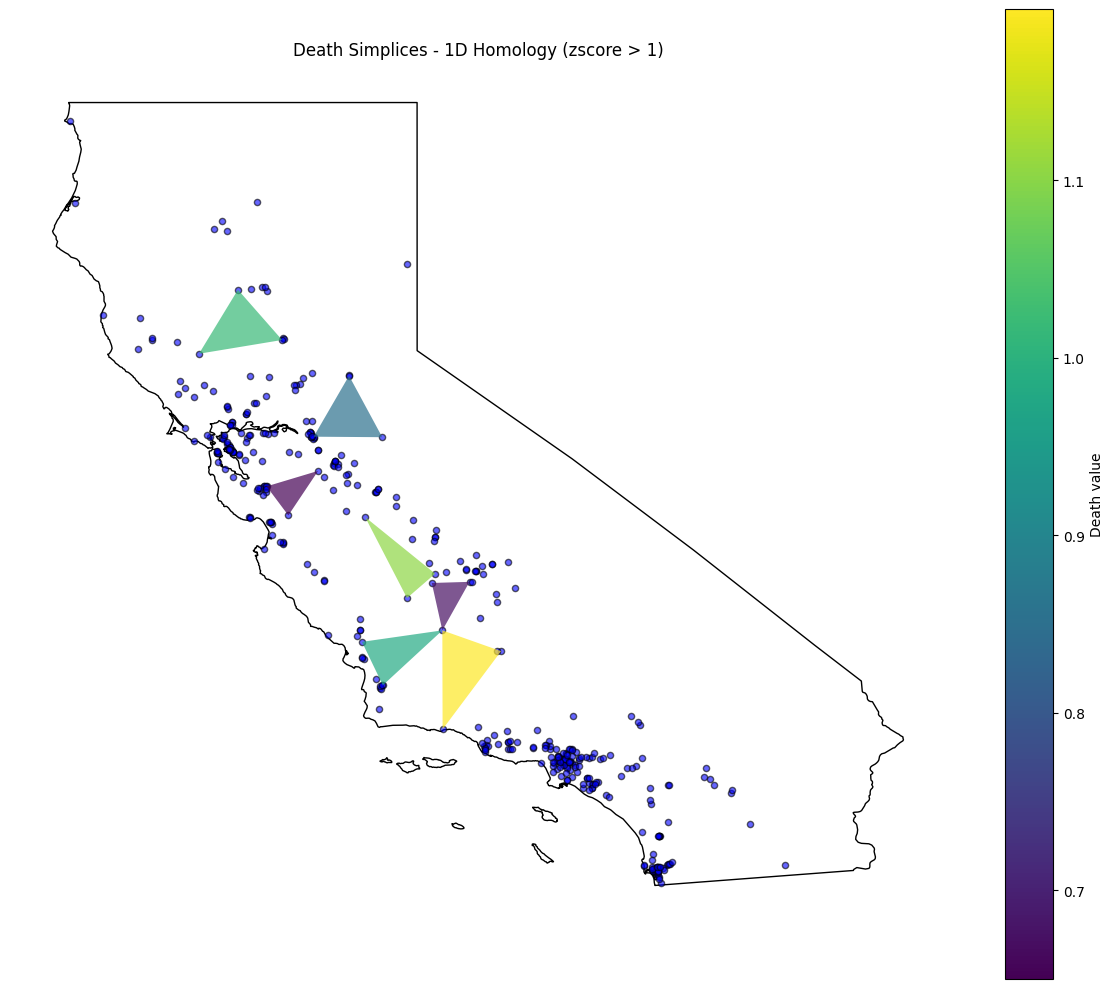

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import contextily as ctx
# Load GeoJSON
gdf = gpd.read_file('output_all.geojson')
#gdf.plot()
#plt.title("Health Centers in California")
import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
states = gpd.read_file(shpfilename)
california = states[states['name'] == 'California']
# Load your health centers
gdf = gpd.read_file('output_all.geojson')

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=50, alpha=0.7)
ax.set_title("Health Centers in California")
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

distance_matrix = np.load('all_d_matrix.npy')

assert len(gdf) == distance_matrix.shape[0] == distance_matrix.shape[1], \
    "Distance matrix dimensions must match number of GeoJSON features"
# Extract coordinates (longitude, latitude) into a NumPy array
#coordinates = np.array(list(gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
# Alternative approaches:
# Method 1: Using get_coordinates() (more efficient for large datasets)
coordinates = gdf.geometry.get_coordinates().values
points = coordinates
#print(points)
# Compute unweighted Rips complex
cpx, ph, all_pairs = get_unweighted_rips_info(points, max_edge_length=200.0, max_hom_dim=1)
# plotting death simplices
#plot_deathsimplices('output_all.geojson', 'all_d_matrix.npy', cpx, all_pairs, 1, , criteria = 'death', zscore_thresh = 1, citydf_fname = None, vmin0 = 3235, vmin1 = 4410, vmax0 = 7380, vmax1 = 7942, legend = False)
# Plot persistence diagram
plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = plt.subplots(1,1)
order_criteria = 'death'
thresh = 1
# REPLACE YOUR FINAL PLOTTING SECTION WITH THIS:

# 1. Plot persistence diagram
simple_persistence_plot(ph)
plt.tight_layout()
plt.show()

# 2. Plot 0D death simplices
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
simple_plot_death_simplices(gdf, cpx, all_pairs, hom_dim=0, ax=ax)
plt.tight_layout()
plt.show()

# 3. Plot 1D death simplices  
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
simple_plot_death_simplices(gdf, cpx, all_pairs, hom_dim=1, ax=ax)
plt.tight_layout()
plt.show()
#plt.show()



In [ ]:
'''# tring better imaging
# Use it:
plt.rcParams['figure.figsize'] = (10, 10)

# Threshold 1
fig, ax = plt.subplots(1, 1)
enhanced_death_simplices_plot(gdf, cpx, all_pairs, 0, ax, zscore_thresh=1)
plt.tight_layout()
plt.show()

# Threshold 2
fig, ax = plt.subplots(2, 3)
enhanced_death_simplices_plot(gdf, cpx, all_pairs, 0, ax, zscore_thresh=2)
plt.tight_layout()
plt.show()'''

"# tring better imaging\n# Use it:\nplt.rcParams['figure.figsize'] = (10, 10)\n\n# Threshold 1\nfig, ax = plt.subplots(1, 1)\nenhanced_death_simplices_plot(gdf, cpx, all_pairs, 0, ax, zscore_thresh=1)\nplt.tight_layout()\nplt.show()\n\n# Threshold 2\nfig, ax = plt.subplots(2, 3)\nenhanced_death_simplices_plot(gdf, cpx, all_pairs, 0, ax, zscore_thresh=2)\nplt.tight_layout()\nplt.show()"

### Running for FQHCs Only

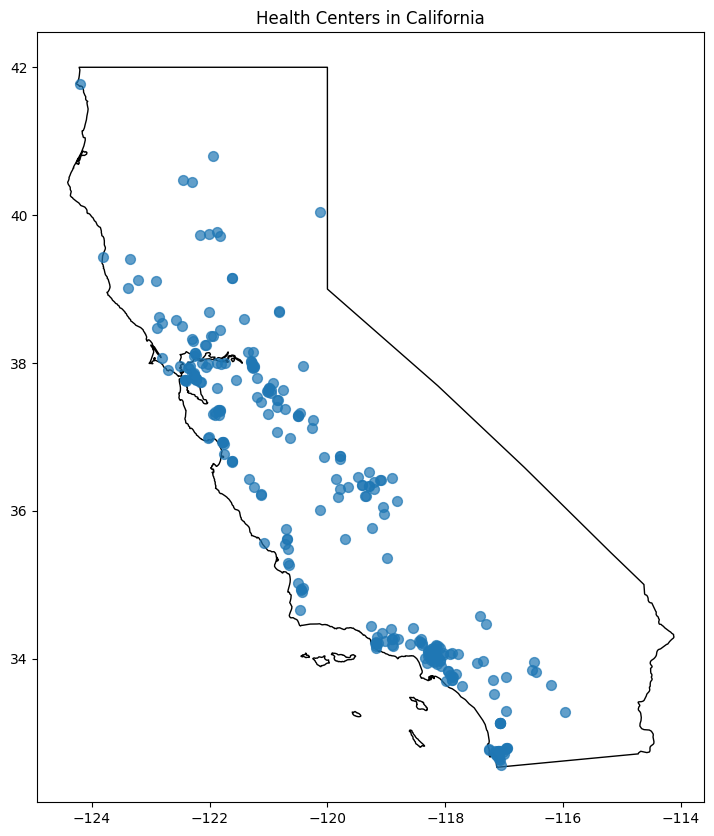

301


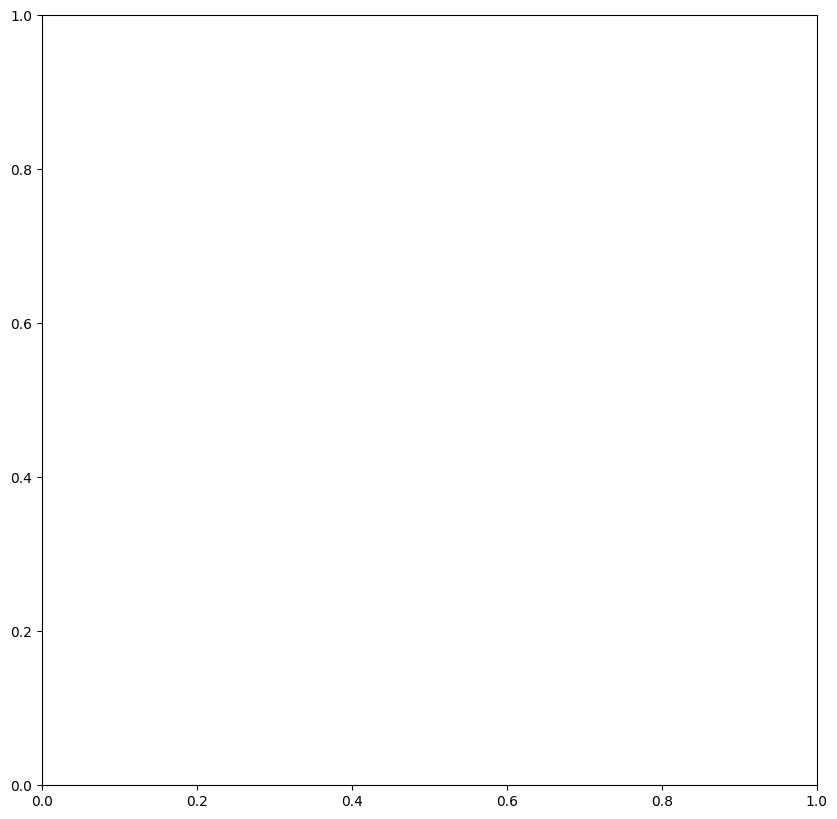

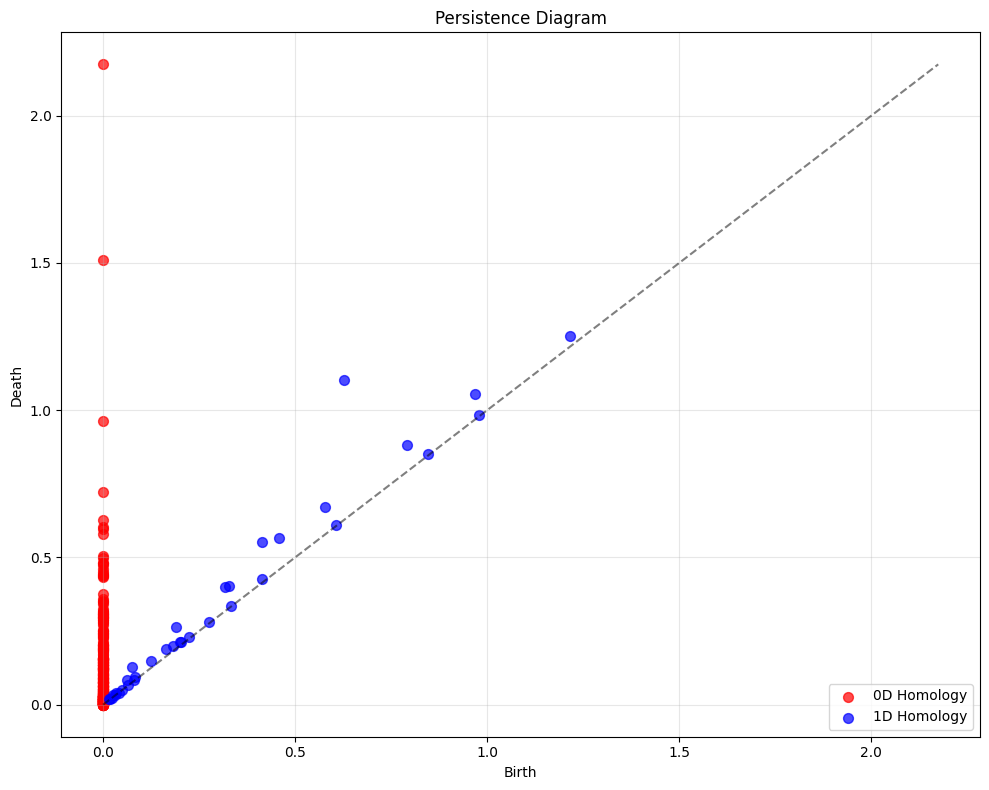

Found 299 finite homology classes in dimension 0
Death simplices above zscore threshold: 25
Plotted 25 death simplices


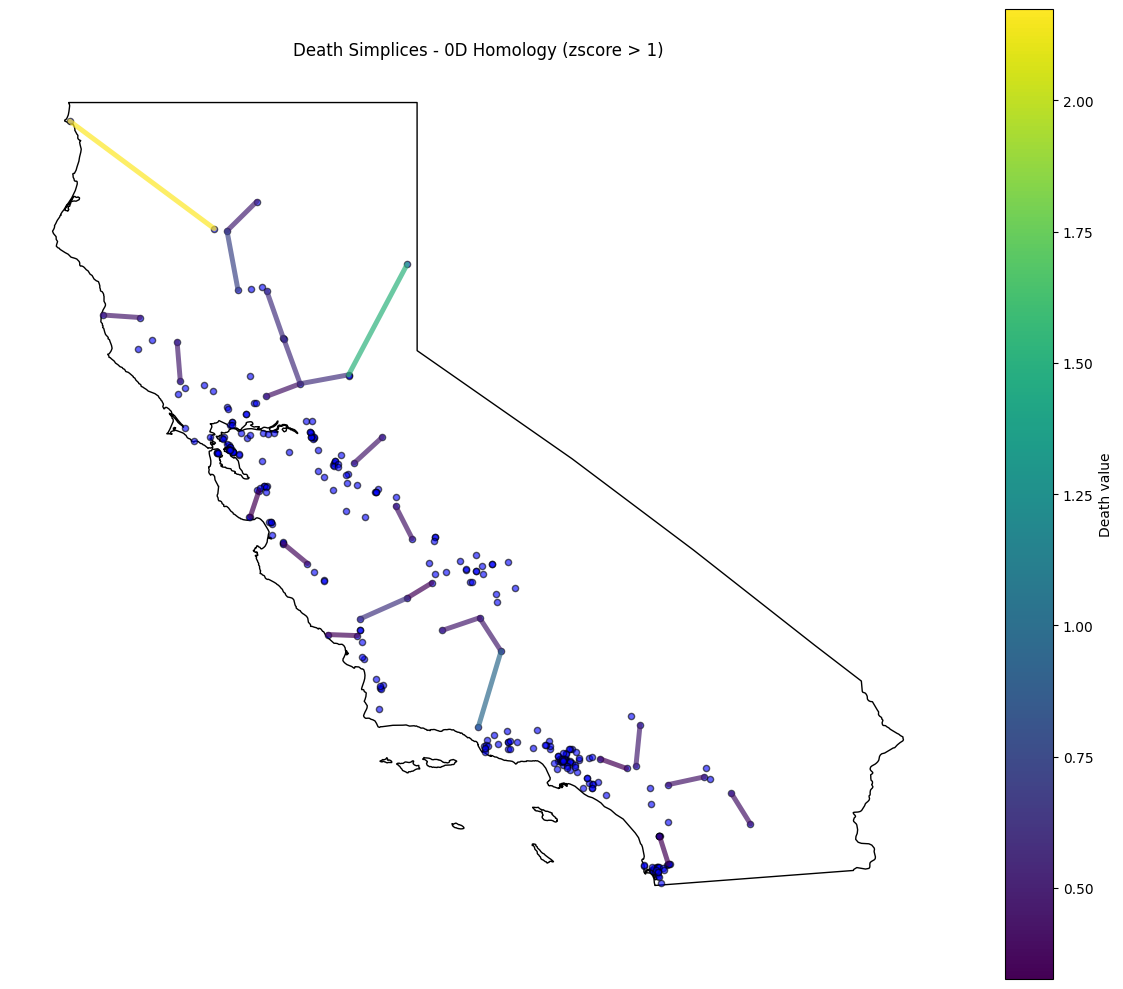

Found 35 finite homology classes in dimension 1
Death simplices above zscore threshold: 6
Plotted 6 death simplices


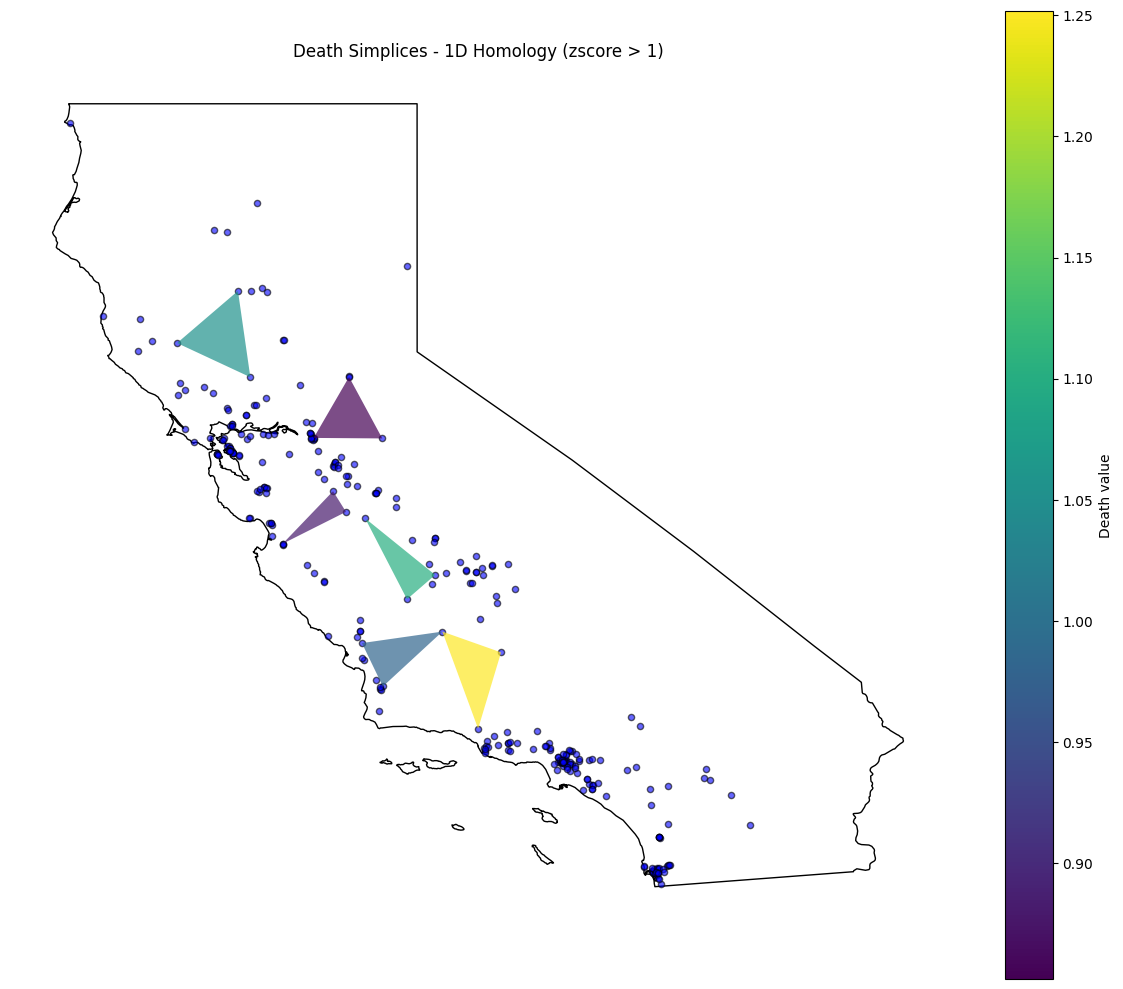

In [ ]:
gdf = gpd.read_file('output_fqhc.geojson')
#gdf.plot()
#plt.title("Health Centers in California")
import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
states = gpd.read_file(shpfilename)
california = states[states['name'] == 'California']
# Load your health centers
gdf = gpd.read_file('output_fqhc.geojson')

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=50, alpha=0.7)
ax.set_title("Health Centers in California")
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

distance_matrix = np.load('fqhc_d_matrix.npy')

assert len(gdf) == distance_matrix.shape[0] == distance_matrix.shape[1], \
    "Distance matrix dimensions must match number of GeoJSON features"
# Extract coordinates (longitude, latitude) into a NumPy array
#coordinates = np.array(list(gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
# Alternative approaches:
# Method 1: Using get_coordinates() (more efficient for large datasets)
coordinates = gdf.geometry.get_coordinates().values
points = coordinates
print(len(points))
#print(points)
# Compute unweighted Rips complex
cpx, ph, all_pairs = get_unweighted_rips_info(points, max_edge_length=2000.0, max_hom_dim=1)
# plotting death simplices
#plot_deathsimplices('output_all.geojson', 'all_d_matrix.npy', cpx, all_pairs, 1, , criteria = 'death', zscore_thresh = 1, citydf_fname = None, vmin0 = 3235, vmin1 = 4410, vmax0 = 7380, vmax1 = 7942, legend = False)
# Plot persistence diagram
plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = plt.subplots(1,1)
order_criteria = 'death'
thresh = 1
# REPLACE YOUR FINAL PLOTTING SECTION WITH THIS:

# 1. Plot persistence diagram
simple_persistence_plot(ph)
plt.tight_layout()
plt.show()

# 2. Plot 0D death simplices
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
simple_plot_death_simplices(gdf, cpx, all_pairs, hom_dim=0, ax=ax)
plt.tight_layout()
plt.show()

# 3. Plot 1D death simplices  
fig, ax = plt.subplots(figsize=(12, 10))
california.plot(ax=ax, color='white', edgecolor='black')
simple_plot_death_simplices(gdf, cpx, all_pairs, hom_dim=1, ax=ax)
plt.tight_layout()
plt.show()